In [43]:
import pandas as pd;
import numpy as np;
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
from tensorflow.keras.layers import Dense, Input, GRU
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet

from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics  

warnings.filterwarnings('ignore')

In [44]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [45]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [46]:
# read the train and the validation file and initialize the batch size
train_doc = np.random.permutation(open('input/train.csv').readlines())
val_doc = np.random.permutation(open('input/val.csv').readlines())

### Generator utility functions

In [47]:
def preprocessImage(image, y, z):
    """
    Helper fucntion to resize & normalize image
    y: height
    z: width
    """
    # resize size image
    image_new = tf.image.resize(image, [y, z], method='nearest')

    
    return image_new/255

In [48]:
def augment_image(image):
    """
    Helper function to perform data augmentation
    """
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    
    # Randomly adjust the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Randomly adjust the contrast of the image
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    
    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image

In [49]:
def getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation):
    '''Function to get Batch Data in generator form'''
    
    # read the tensor image and get the x,y,z info
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    
    # list of folder indices
    img_idx = img_tensor[0]
    
    # create a batch_data and batch_labels
    # x is the number of images you use for each video, 
    #(y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_data = np.zeros((batch_size,x,y,z,3)) 
    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((batch_size,5)) 
    
    # if augmentation is set to true
    # create the augmented data
    if (augmentation): 
        batch_data_aug = np.zeros((batch_size,x,y,z,3))
        batch_labels_aug = np.zeros((batch_size,5))
    
    # iterate over the batch_size
    for folder in range(batch_size):
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        
        #  Iterate iver the frames/images of a folder to read them in
        for idx,item in enumerate(img_idx):
            imgPath = source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
            image = tf.io.read_file(imgPath)
            image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image with 3 channels (RGB)    

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            # populate the batch data
            preProcessImage = preprocessImage(image, y, z)
            batch_data[folder,idx,:,:,:] = preProcessImage
            
            if(augmentation):
                batch_data_aug[folder, idx,:,:,:] = augment_image(preProcessImage)
        
        # populate the label data one-hot encoding
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
    # condition checks whether data augmentation is enabled
    if (augmentation):
        batch_data=tf.concat([batch_data,batch_data_aug], axis=0)
        batch_labels=tf.concat([batch_labels,batch_labels], axis=0)
    
    return batch_data, batch_labels

In [50]:
def generator(source_path, folder_list, batch_size, img_tensor, augmentation):
    '''Function to generate the batch data'''
    
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        # get the random folder list
        t = np.random.permutation(folder_list)
        
        # number of batches 
        num_batches = int(len(folder_list)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor, augmentation)

### Set the parameters

In [51]:
curr_dt_time = datetime.datetime.now()
train_path = 'input/train'
val_path = 'input/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batchSize =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batchSize = 30


### Function to set image tensors

In [52]:
def getImgTensor(n_frames, size):
    """
    size: image size
    """
    img_idx = np.round(np.linspace(0, n_frames-1, n_frames)).astype(int)
    return [img_idx, size, size, 3]

# define image tensor size
img_tensor = getImgTensor(30, 100)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]


In [53]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor, False)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  input/train ; batch size = 30
(30, 30, 100, 100, 3)
Source path =  input/val ; batch size = 30
(30, 30, 100, 100, 3)


In [54]:
 y = ['LeftSwipe', 'RightSwipe', 'Stop', 'ThumbsDown', 'ThumbsUp']

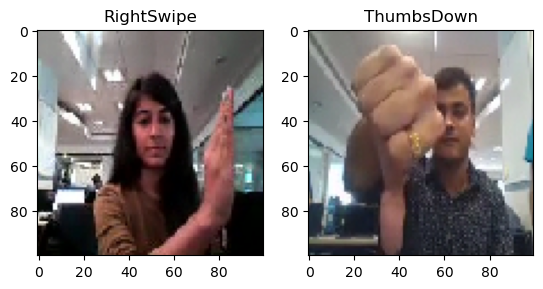

In [55]:
# lets plot some sample images
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:]) 
ax[0].title.set_text(f"{y[np.argmax(sample_val_batch_labels[16])]}")
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
ax[1].title.set_text(f"{y[np.argmax(sample_val_batch_labels[25])]}")
plt.show()

In [56]:
# lets test with augmentation
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor, True)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  input/train ; batch size = 30
(60, 30, 100, 100, 3)
Source path =  input/val ; batch size = 30
(60, 30, 100, 100, 3)


### Model Utility Functions

In [57]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))
    
def callbacks(modelName):
    model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-keras.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    callbacks_list = [checkpoint, LR]
    #callbacks_list = [LR]
    
    return callbacks_list

def get_acc_loss(history):
    
    loss_train = history.history['loss'][-1]
    accuracy_train = history.history['categorical_accuracy'][-1]

    loss_val = history.history['val_loss'][-1]
    accuracy_val = history.history['val_categorical_accuracy'][-1]

    print(f"\nThe accuracy of the training ::: {accuracy_train:.3f}")
    print(f"The loss of the training ::: {loss_train:.3f}")
    print("\n")
    print(f"The accuracy of the validation ::: {accuracy_val:.3f}")
    print(f"The loss of the validation ::: {loss_val:.3f}")

    return loss_train, accuracy_train, loss_val, accuracy_val


def getF1Score(actual_class_val, pred_class_val):
    # compute the f1_score
    #f1_train = metrics.f1_score(actual_class_train, pred_class_train, average='weighted')
    f1_val = metrics.f1_score(actual_class_val, pred_class_val, average='weighted')

    #print(f"\nThe F1 Score of the training ::: {f1_train:.3f}")
    print(f"The F1 Score is ::: {f1_val:.3f}")

    return f1_val

def confusionMatrix(actual_class, pred_class, y, modelName):
    '''Function to get the confusion matrix '''
    conf_matrix = confusion_matrix(actual_class, pred_class)
    
    print("\nConfusion Matrix:::")
    print(conf_matrix)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(6, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=y, yticklabels=y)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix Heatmap - {modelName}')
    plt.savefig(f'report/confusionMatrix_{modelName}.png')
    plt.show()

    return conf_matrix

def getPredClass(y_actual, y_pred):
    '''Function to get the prediction class'''
    # check the prediction classes
    actual_class = y_actual.argmax(axis=1)
    pred_class = y_pred.argmax(axis=1)

    return actual_class, pred_class

def printClassificationReport(actual_class, pred_class, y):
    'Print the classification Report'
    report = classification_report(actual_class, pred_class, target_names=y)
    print(report)

    return report

def showReport(y_actual, y_pred, modelName):
    '''Funciton to show the report'''

    y = ['LeftSwipe', 'RightSwipe', 'Stop', 'ThumbsDown', 'ThumbsUp']

    #actual_class , pred_class = getPredClass(y_actual, y_pred)
    conf_matrix = confusionMatrix(y_actual, y_pred, y, modelName)
    class_report = printClassificationReport(y_actual, y_pred, y)

    return conf_matrix, class_report

def validate_data(model):
    '''Function to validate data'''
    # Create empty lists to store the actual and predicted labels for validaiton data 
    actual_labels = []
    predicted_labels = []

    # Iterate over the generator to obtain the actual labels
    for i in range(validation_steps):
        # Get the next batch of images and labels from the generator
        batch_x, batch_y = next(val_generator)

        # campture the sample data
        sample_batch_x = batch_x

        # Convert one-hot encoded labels to class indices
        actual_labels.extend(np.argmax(batch_y, axis=1))

        # Make predictions for the batch
        predictions = model.predict(batch_x)

        # Convert predicted probabilities to class indices
        predicted_labels.extend(np.argmax(predictions, axis=1))
        
    return actual_labels, predicted_labels

def computeSteps(num_train_sequences, num_val_sequences, batch_size):
    '''Function to compute steps'''
    
    # compute the steps per epoch for train and validation
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    return steps_per_epoch, validation_steps

In [58]:
# Empty dataframe to store the results
results_multiclass = pd.DataFrame({'model':[],
                        'epochs':[],
                        'batch_size':[],
                        'n_frames':[],
                        'training_loss':[],
                        'training_accuracy':[],
                        'validation_loss':[],
                        'validation_accuracy':[],
                        'validation_f1':[],
                        'validation_recall':[],
                        'validation_precision':[]})
results_multiclass.T

""
model
epochs
batch_size
n_frames
training_loss
training_accuracy
validation_loss
validation_accuracy
validation_f1
validation_recall


### Model Building

In [59]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [60]:
# Base Model
def defineModel(img_tensor):
    '''
    Function to define the base model
    We use Conv3D with different filters and size
    We use maxpooling3D of different size and BathNormalization
    We also use Dropout(0.25)
    '''
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, (make3dFilter(5)), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_26 (Conv3D)              │ (None, 26, 96, 96, 16) │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 13, 48, 48, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 13, 48, 48, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_27 (Conv3D)              │ (None, 11, 46, 46, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 11, 23, 23, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 11, 23, 23, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_28 (Conv3D)              │ (None, 9, 21, 21, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 9, 11, 11, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 9, 11, 11, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 69696)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     8,921,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,006,245 (34.36 MB)

 Trainable params: 9,005,637 (34.35 MB)

 Non-trainable params: 608 (2.38 KB)

**NOTE: The generator has to be run everytime for different models**

In [61]:
# Initialize the generators
# we are augmenting data for the training but not for the validation
train_generator = generator(train_path, train_doc, batch_size, img_tensor, False)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [62]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [63]:
# initialize the callback
callback_list = callbacks('BaseModel')

In [64]:
# Train the model
history_base= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 30
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.3865 - loss: 1.8189Source path =  input/val ; batch size = 30

Epoch 1: val_loss improved from inf to 4.48826, saving model to BaseModel_2024-05-2815_47_48.435587/model-keras.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step - categorical_accuracy: 0.3885 - loss: 1.8102 - val_categorical_accuracy: 0.2400 - val_loss: 4.4883 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - categorical_accuracy: 0.4980 - loss: 1.2732
Epoch 2: val_loss did not improve from 4.48826
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.4990 - loss: 1.2763 - val_categorical_accuracy: 0.2250 - val_loss: 8.3380 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - categorical_accuracy: 0.5848 - loss: 1.3668
Epoch 3: val_loss did not improve from 4.48826
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - categorical_accuracy: 0.5809 - loss: 1.37

Epoch 21/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - categorical_accuracy: 0.2474 - loss: 1.7320
Epoch 21: val_loss improved from 1.71965 to 1.48833, saving model to BaseModel_2024-05-2815_47_48.435587/model-keras.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - categorical_accuracy: 0.2486 - loss: 1.7332 - val_categorical_accuracy: 0.3750 - val_loss: 1.4883 - learning_rate: 8.0000e-06
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - categorical_accuracy: 0.2577 - loss: 1.9120
Epoch 22: val_loss did not improve from 1.48833
23/23 ━━━━━━━━━━━━━━━━━━━━ 526s 24s/step - categorical_accuracy: 0.2573 - loss: 1.9136 - val_categorical_accuracy: 0.2750 - val_loss: 1.8582 - learning_rate: 8.0000e-06
Epoch 23/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - categorical_accuracy: 0.2571 - loss: 1.6544 
Epoch 23: val_loss did not improve from 1.48833
23/23 ━━━━━━━━━━━━━━━━━━━━ 721s 33s/step - categorical_accuracy: 0.2615 - loss: 1.6468 - val_categorical_accuracy: 0.3750 - val_loss: 1.8889 - learni

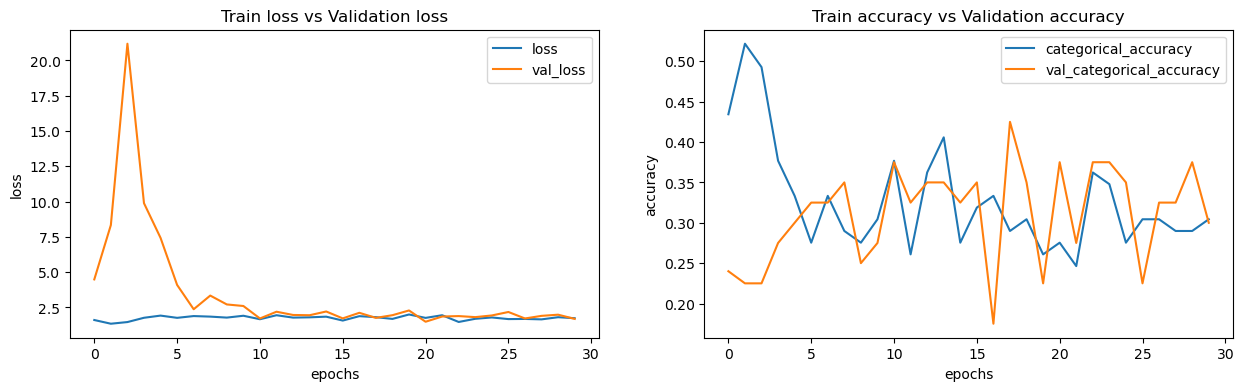

Max. Training Accuracy 0.52173912525177
Max. Validation Accuracy 0.42500001192092896


In [65]:
# print the history
plotModelHistory(history_base)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step

Confusion Matrix:::
[[2 0 0 1 1]
 [3 4 1 1 1]
 [1 1 1 0 5]
 [3 0 0 3 4]
 [0 1 2 0 5]]


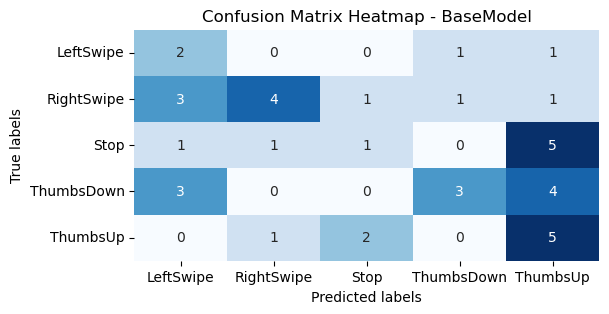

              precision    recall  f1-score   support

   LeftSwipe       0.22      0.50      0.31         4
  RightSwipe       0.67      0.40      0.50        10
        Stop       0.25      0.12      0.17         8
  ThumbsDown       0.60      0.30      0.40        10
    ThumbsUp       0.31      0.62      0.42         8

    accuracy                           0.38        40
   macro avg       0.41      0.39      0.36        40
weighted avg       0.45      0.38      0.37        40



In [66]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'BaseModel')

In [67]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_base)


The accuracy of the training ::: 0.304
The loss of the training ::: 1.739


The accuracy of the validation ::: 0.300
The loss of the validation ::: 1.691


In [68]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.37243589743589745

In [69]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [70]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['BaseModel', num_epochs, batch_size, n_frames, loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [71]:
results_multiclass.T

,0
model,BaseModel
epochs,30
batch_size,30
n_frames,20
training_loss,1.738539
training_accuracy,0.304348
validation_loss,1.690626
validation_accuracy,0.3
validation_f1,0.372436
validation_recall,0.375


### Model 2

**CONV2D + LSTM (Long short Term Memory)**

In [72]:
# initialize parameters
n_frames = 20
num_epochs = 30
batch_size = 30

In [73]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [74]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [75]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM')

In [76]:
def defineModel(img_tensor):
    '''
    Function for the CONV2D and LSTM model
    We use BatchNormalization and Maxpooling2D(2,2) and Dropout(0.2)
    Activation is relu in all layer with softmax in output
    '''
    
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(make2dFilter(2))),

        TimeDistributed(Flatten()),
        LSTM(256),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ], name="conv_2d_lstm")
    
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "conv_2d_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_29             │ (None, 20, 128, 128,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 20, 128, 128,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 20, 64, 64, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 20, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 20, 32, 32, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 20, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 20, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 20, 16, 16,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 20, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 20, 8, 8, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 20, 8, 8, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 20, 4, 4, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 20, 4096)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │     4,457,47

 Total params: 4,919,141 (18.77 MB)

 Trainable params: 4,918,149 (18.76 MB)

 Non-trainable params: 992 (3.88 KB)

In [77]:
# Initialize the generators
# we are augmenting data for the training but not for the validation
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [78]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [79]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM')

In [80]:
# Train the model
history_C2D_LSTM= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 30
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - categorical_accuracy: 0.3238 - loss: 1.5125 Source path =  input/val ; batch size = 30

Epoch 1: val_loss improved from inf to 1.81224, saving model to Conv2D_LSTM_2024-05-2815_47_48.435587/model-keras.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 522s 22s/step - categorical_accuracy: 0.3253 - loss: 1.5089 - val_categorical_accuracy: 0.2100 - val_loss: 1.8122 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3914 - loss: 1.4233
Epoch 2: val_loss improved from 1.81224 to 1.53283, saving model to Conv2D_LSTM_2024-05-2815_47_48.435587/model-keras.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - categorical_accuracy: 0.3890 - loss: 1.4275 - val_categorical_accuracy: 0.2500 - val_loss: 1.5328 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2549 - loss: 1.6570
Epoch 3: val_loss did not improve from 1.53283
23/23 

Epoch 21/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3707 - loss: 1.3761
Epoch 21: val_loss did not improve from 1.11969
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - categorical_accuracy: 0.3713 - loss: 1.3751 - val_categorical_accuracy: 0.5750 - val_loss: 1.1332 - learning_rate: 8.0000e-06
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3795 - loss: 1.4339
Epoch 22: val_loss did not improve from 1.11969
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - categorical_accuracy: 0.3784 - loss: 1.4328 - val_categorical_accuracy: 0.5500 - val_loss: 1.2165 - learning_rate: 8.0000e-06
Epoch 23/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4406 - loss: 1.3419
Epoch 23: val_loss did not improve from 1.11969
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - categorical_accuracy: 0.4395 - loss: 1.3424 - val_categorical_accuracy: 0.5500 - val_loss: 1.1412 - learning_rate: 8.0000e-06
Epoch 24/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_acc

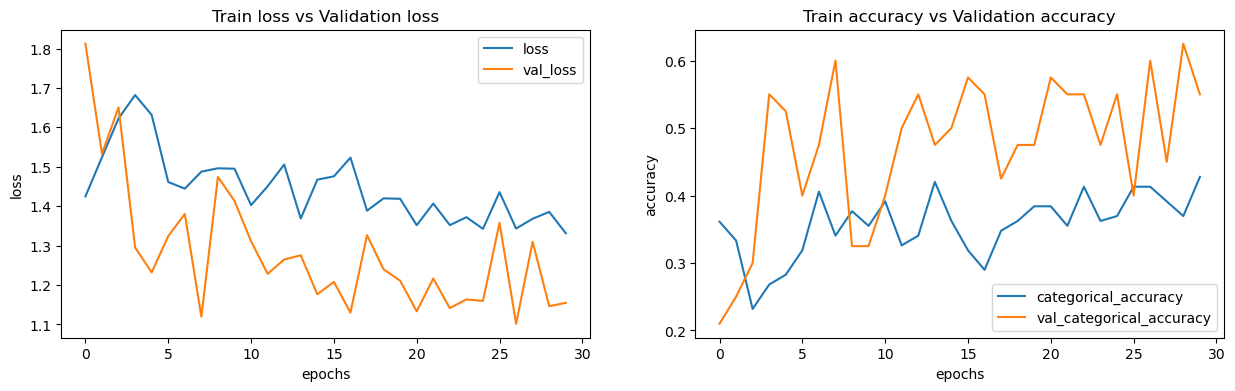

Max. Training Accuracy 0.4275362193584442
Max. Validation Accuracy 0.625


In [81]:
# print the history
plotModelHistory(history_C2D_LSTM)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

Confusion Matrix:::
[[ 1  0  0  2  2]
 [ 2  8  0  0  0]
 [ 1  4  0  2  1]
 [ 0  0  1 10  0]
 [ 0  0  0  2  4]]


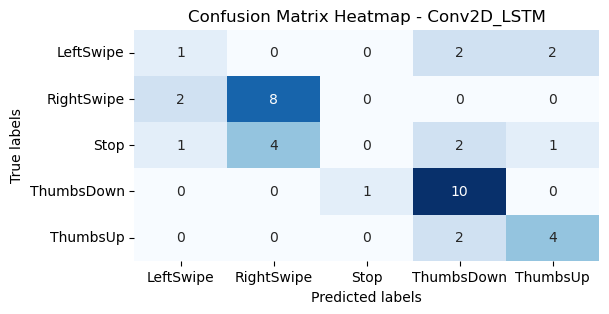

              precision    recall  f1-score   support

   LeftSwipe       0.25      0.20      0.22         5
  RightSwipe       0.67      0.80      0.73        10
        Stop       0.00      0.00      0.00         8
  ThumbsDown       0.62      0.91      0.74        11
    ThumbsUp       0.57      0.67      0.62         6

    accuracy                           0.57        40
   macro avg       0.42      0.52      0.46        40
weighted avg       0.46      0.57      0.51        40



In [82]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'Conv2D_LSTM')

In [83]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_C2D_LSTM)


The accuracy of the training ::: 0.428
The loss of the training ::: 1.331


The accuracy of the validation ::: 0.550
The loss of the validation ::: 1.155


In [84]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.5056073556073557

In [85]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [86]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['Conv2D_LSTM', num_epochs, batch_size, n_frames, loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [87]:
results_multiclass.T

,0,1
model,BaseModel,Conv2D_LSTM
epochs,30,30
batch_size,30,30
n_frames,20,20
training_loss,1.738539,1.331281
training_accuracy,0.304348,0.427536
validation_loss,1.690626,1.15481
validation_accuracy,0.3,0.55
validation_f1,0.372436,0.505607
validation_recall,0.375,0.575


### Model 3

**CONV2D with LSTM having 16 frames for 20 epochs**

In [88]:
# initialize parameters
n_frames = 16
num_epochs = 20
batch_size = 32

In [89]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 100)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, True)
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [90]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [91]:
# initialize the callback
callback_list = callbacks('Conv2D_LSTM_16F')

In [92]:
# define the same model with different tensor shape
model = defineModel(img_tensor)
model.summary()

Model: "conv_2d_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_45             │ (None, 16, 100, 100,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 16, 100, 100,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 16, 50, 50, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 16, 50, 50, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 16, 50, 50, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 16, 25, 25, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 16, 25, 25, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 16, 25, 25, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 16, 12, 12, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 16, 12, 12,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 16, 12, 12,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 16, 6, 6, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 16, 6, 6, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 16, 6, 6, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 16, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 16, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │     2,622,46

 Total params: 3,084,133 (11.77 MB)

 Trainable params: 3,083,141 (11.76 MB)

 Non-trainable params: 992 (3.88 KB)

In [93]:
# Train the model
history_C2D_LSTM_16F= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 32
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2742 - loss: 1.5650Source path =  input/val ; batch size = 32

Epoch 1: val_loss improved from inf to 2.43141, saving model to Conv2D_LSTM_16F_2024-05-2815_47_48.435587/model-keras.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - categorical_accuracy: 0.2785 - loss: 1.5584 - val_categorical_accuracy: 0.2100 - val_loss: 2.4314 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4773 - loss: 1.2211
Epoch 2: val_loss improved from 2.43141 to 0.94760, saving model to Conv2D_LSTM_16F_2024-05-2815_47_48.435587/model-keras.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - categorical_accuracy: 0.4781 - loss: 1.2211 - val_categorical_accuracy: 0.6875 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4608 - loss: 1.2758
Epoch 3: val_loss did not improve from 0.94760


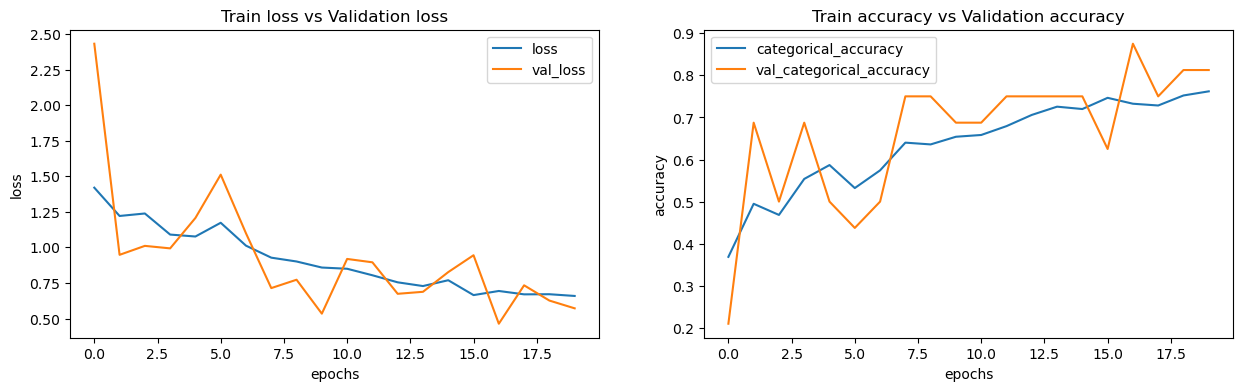

Max. Training Accuracy 0.761904776096344
Max. Validation Accuracy 0.875


In [94]:
# print the history
plotModelHistory(history_C2D_LSTM_16F)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Confusion Matrix:::
[[1 1 0 0 1]
 [0 4 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 2]]


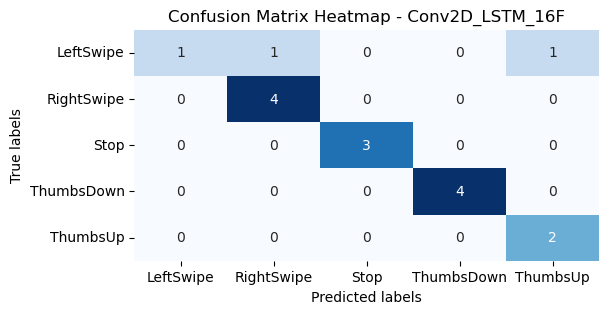

              precision    recall  f1-score   support

   LeftSwipe       1.00      0.33      0.50         3
  RightSwipe       0.80      1.00      0.89         4
        Stop       1.00      1.00      1.00         3
  ThumbsDown       1.00      1.00      1.00         4
    ThumbsUp       0.67      1.00      0.80         2

    accuracy                           0.88        16
   macro avg       0.89      0.87      0.84        16
weighted avg       0.91      0.88      0.85        16



In [95]:
# validation data check
actual_labels, predicted_labels = validate_data(model)
# show the classification report and confusion matrix
conf_matrix, class_report = showReport(actual_labels, predicted_labels, 'Conv2D_LSTM_16F')

In [96]:
# get the accuracy and loss of training
loss_train, acc_train, loss_val, acc_val = get_acc_loss(history_C2D_LSTM_16F)


The accuracy of the training ::: 0.762
The loss of the training ::: 0.659


The accuracy of the validation ::: 0.812
The loss of the validation ::: 0.572


In [97]:
f1_val = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
f1_val

0.8534722222222222

In [98]:
# get the precision and recall
avg_recal_val = metrics.recall_score(actual_labels, predicted_labels, average='weighted')
avg_preci_val = metrics.precision_score(actual_labels, predicted_labels, average='weighted')

In [99]:
# add data to dataframe
results_multiclass.loc[len(results_multiclass)] = ['Conv2D_LSTM_16F', num_epochs, batch_size, n_frames, loss_train, acc_train, loss_val, acc_val,
                                                   f1_val, avg_recal_val, avg_preci_val]

In [100]:
results_multiclass.T

,0,1,2
model,BaseModel,Conv2D_LSTM,Conv2D_LSTM_16F
epochs,30,30,20
batch_size,30,30,32
n_frames,20,20,16
training_loss,1.738539,1.331281,0.658571
training_accuracy,0.304348,0.427536,0.761905
validation_loss,1.690626,1.15481,0.571543
validation_accuracy,0.3,0.55,0.8125
validation_f1,0.372436,0.505607,0.853472
validation_recall,0.375,0.575,0.875


### Model 4

**Transfer learning Mobilenet with LSTM**

**Here we are using a pretrained model mobilenet and using LSTM to see if the model performs good**

In [108]:
# initialize the parameters
n_frames = 30
num_epochs = 20
batch_size = 10

In [109]:
# get the image tensor and initialize the new train generator and val_generator
img_tensor = getImgTensor(n_frames, 128)
train_generator = generator(train_path, train_doc, batch_size, img_tensor, False) # augmentation is False
val_generator = generator(val_path, val_doc, batch_size, img_tensor, False)

In [110]:
# compute the steps for training and validation
steps_per_epoch, validation_steps = computeSteps(num_train_sequences, num_val_sequences, batch_size)

In [111]:
# initialize the callback
callback_list = callbacks('CONV3D_linear')

In [105]:
# GestureClassifier(
#   (conv1): Conv3d(1, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
#   (bn1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (dropout1): Dropout(p=0.2, inplace=False)

#   (conv2): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
#   (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (dropout2): Dropout(p=0.2, inplace=False)

#   (conv3): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
#   (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (dropout3): Dropout(p=0.2, inplace=False)

#   (conv4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
#   (bn4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (dropout4): Dropout(p=0.2, inplace=False)

#   (avergaepool): AdaptiveAvgPool3d(output_size=1)
#   (hybridpool): HybridPool3d(
#     (avg_pool): AdaptiveAvgPool3d(output_size=1)
#     (max_pool): AdaptiveMaxPool3d(output_size=1)
#   )
#   (fc1): Linear(in_features=256, out_features=512, bias=True)
#   (fc2): Linear(in_features=512, out_features=64, bias=True)
#   (fc3): Linear(in_features=64, out_features=5, bias=True)
# )
# torch.Size([8, 5])

In [112]:
# Base Model
def defineModel(img_tensor):
    '''
    Function to define the base model
    We use Conv3D with different filters and size
    We use GloabalAvgPool3D with BathNormalization
    Here we are using linear activation 
    After the CNN there are 3 Dense layers 
    We also use Dropout(0.2)
    '''
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(256, (make3dFilter(3)), activation='linear', input_shape=inputShape),
        BatchNormalization(),
        Dropout(0.2),

        Conv3D(128, make3dFilter(3), activation='linear'),
        BatchNormalization(),
        Dropout(0.2),

        Conv3D(64, make3dFilter(3), activation='linear'),
        BatchNormalization(),
        Dropout(0.2),
        
        Conv3D(128, make3dFilter(3), activation='linear'),
        BatchNormalization(),
        Dropout(0.2),

        GlobalAveragePooling3D(),
        #MaxPooling3D()
        
        Dense(256, activation='linear'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(512, activation='linear'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='linear'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(5, activation='softmax')
    ], name='CON3D_linear')
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "CON3D_linear"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_33 (Conv3D)              │ (None, 28, 126, 126,   │        20,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 28, 126, 126,   │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 28, 126, 126,   │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_34 (Conv3D)              │ (None, 26, 124, 124,   │       884,864 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 26, 124, 124,   │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 26, 124, 124,   │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_35 (Conv3D)              │ (None, 24, 122, 122,   │       221,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 24, 122, 122,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 24, 122, 122,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_36 (Conv3D)              │ (None, 22, 120, 120,   │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 22, 120, 120,   │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 22, 120, 120,   │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 512)            │         2,04

 Total params: 1,551,813 (5.92 MB)

 Trainable params: 1,548,997 (5.91 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
# Train the model
history_C3D_linear= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callback_list, validation_data=val_generator, 
                        validation_steps=validation_steps)

Source path =  input/train ; batch size = 10
Epoch 1/20
